In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import f1_score
from sklearn import ensemble
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm, model_selection
from sklearn import neighbors
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder

In [2]:
#--Importing dataset

# Change it to your absolut path
abs_path = '../'

df_users=pd.read_csv(abs_path+"/data/raw/usagers-2021.csv", sep=";")
df_places=pd.read_csv(abs_path+"/data/raw/lieux-2021.csv", sep=";", header=0, low_memory=False)
df_caract=pd.read_csv(abs_path+"/data/raw/caracteristiques-2021.csv", sep = ";", encoding='utf-8')
df_veh=pd.read_csv(abs_path + "/data/raw/vehicules-2021.csv", sep=";")


# DataSet Users 

In [3]:
#--Visualizing dataset users 

df_users.head(15)
df_users['grav'].value_counts(normalize=True)

 1    0.426688
 4    0.400153
 3    0.147770
 2    0.024924
-1    0.000465
Name: grav, dtype: float64

In [4]:
#--Calculating the number of victims by accident 

nb_victim = pd.crosstab(df_users.Num_Acc, "count").reset_index()

print(nb_victim)

col_0       Num_Acc  count
0      202100000001      2
1      202100000002      2
2      202100000003      2
3      202100000004      2
4      202100000005      2
...             ...    ...
56513  202100056514      1
56514  202100056515      1
56515  202100056516      2
56516  202100056517      1
56517  202100056518      2

[56518 rows x 2 columns]


In [5]:
#-- Calculating the number of vehicles involved in the accident 
nb_vehicules = pd.crosstab(df_veh.Num_Acc, "count").reset_index()

In [6]:
#--Changing the number associated to injured to make more sens

df_users.grav.replace([1,2,3,4], [1,3,4,2], inplace = True)

In [7]:
#--Removing variables secu2 and secu3 because they don't bring anything relevant 
df_users.drop(["secu2", "secu3"], inplace=True, axis=1)

In [8]:
#--Adding the age of the victims at the time of the accident

#-Extracting the year of the accident thanks to the accident number
df_users["year_acc"] = df_users["Num_Acc"].astype(str).apply(lambda x : x[:4]).astype(int)

#-Calculating the age the victim
df_users["victim_age"] = df_users["year_acc"]-df_users["an_nais"]
for i in df_users["victim_age"] :
  #- Replacing outliers by NaN
  if (i>120)|(i<0):
    df_users["victim_age"].replace(i,np.nan)

df_users.drop(["year_acc","an_nais"], inplace=True, axis=1)

In [9]:
df_users.isna().sum()

Num_Acc           0
id_vehicule       0
num_veh           0
place             0
catu              0
grav              0
sexe              0
trajet            0
secu1             0
locp              0
actp              0
etatp             0
victim_age     3067
dtype: int64

# Dataset Caracteristics

In [10]:
df_caract.head()

,Num_Acc,jour,mois,an,hrmn,lum,dep,com,agg,int,atm,col,adr,lat,long
0,202100000001,30,11,2021,07:32,2,30,30319,1,1,1,1,CD 981,"44,0389580000","4,3480220000"
1,202100000002,25,9,2021,14:20,1,51,51544,1,3,1,3,Aire de repos croisement D20E9 aprÃ¨s sortie D977,"49,2421290000","4,5545460000"
2,202100000003,15,7,2021,07:55,1,85,85048,2,1,7,6,15 rue FranÃ§ois Nicolas,"46,9219500000","-0,9644600000"
3,202100000004,27,3,2021,19:45,5,93,93005,2,2,3,6,Route de Mitry,"48,9493634583","2,5196639908"
4,202100000005,25,2,2021,07:20,5,76,76429,2,1,1,2,PARIS. ROUTE DE,"49,4083800000","1,1458100000"


In [11]:
#--Replacing column named agg by agg_ since agg is a Python method

df_caract.rename({"agg" : "agg_"},  inplace = True, axis = 1)

In [12]:
#--Replacing Corsica code 2A and 2B by 201 and 202 
corse_replace = {"2A":"201", "2B":"202"}
df_caract["dep"] = df_caract["dep"].str.replace("2A", "201")
df_caract["dep"] = df_caract["dep"].str.replace("2B", "202")
df_caract["com"] = df_caract["com"].str.replace("2A", "201")
df_caract["com"] = df_caract["com"].str.replace("2B", "202")

In [13]:
#--Creating a column datetime
df_caract['datetime_str'] = df_caract['jour'].astype(str) + '/' + df_caract['mois'].astype(str) + '/' + df_caract['an'].astype(str) + ' ' + df_caract['hrmn']
df_caract['datetime'] = pd.to_datetime(df_caract['datetime_str'], format='%d/%m/%Y %H:%M')
df_caract.drop(columns=['datetime_str'], inplace=True)
df_caract["datetime"].sort_values()


56496   2021-01-01 00:00:00
56495   2021-01-01 00:40:00
56132   2021-01-01 00:45:00
56419   2021-01-01 01:00:00
56410   2021-01-01 01:40:00
                ...        
708     2021-12-31 22:45:00
388     2021-12-31 23:00:00
702     2021-12-31 23:30:00
472     2021-12-31 23:40:00
799     2021-12-31 23:50:00
Name: datetime, Length: 56518, dtype: datetime64[ns]

In [14]:
#--Creating a column hour that will replace hrmn

df_caract["hour"] = df_caract["hrmn"].astype(str).apply(lambda x : x[:-3])
df_caract.drop(['hrmn'], inplace=True, axis=1)

In [15]:
#--Convertir columns dep, com and hour into type int
df_caract[["dep","com", "hour"]] = df_caract[["dep","com", "hour"]].astype(int)


In [16]:
#--Converting columns lat and long into float type

dico_to_float = { 'lat': float, 'long':float}

df_caract["lat"] = df_caract["lat"].str.replace(',', '.')
df_caract["long"] = df_caract["long"].str.replace(',', '.')
df_caract = df_caract.astype(dico_to_float)

df_caract.dtypes

Num_Acc              int64
jour                 int64
mois                 int64
an                   int64
lum                  int64
dep                  int64
com                  int64
agg_                 int64
int                  int64
atm                  int64
col                  int64
adr                 object
lat                float64
long               float64
datetime    datetime64[ns]
hour                 int64
dtype: object

In [17]:
#--Removing variable adr because not usable

df_caract = df_caract.drop(columns = 'adr')

In [18]:
df_caract.shape

(56518, 15)

In [19]:
#--Grouping the modalities of the atm ( Atmosheric Conditions) variable into 1 : Risky and 0 : Normal. We include Other in Normal.
print("Modalities of the variable atm : ", df_caract['atm'].unique())
dico = {1:0, 2:1, 3:1, 4:1, 5:1, 6:1,7:1, 8:0, 9:0}
df_caract["atm"] = df_caract["atm"].replace(dico)
df_caract.head()

Modalities of the variable atm :  [ 1  7  3  2  8  9  5  4 -1  6]


,Num_Acc,jour,mois,an,lum,dep,com,agg_,int,atm,col,lat,long,datetime,hour
0,202100000001,30,11,2021,2,30,30319,1,1,0,1,44.038958,4.348022,2021-11-30 07:32:00,7
1,202100000002,25,9,2021,1,51,51544,1,3,0,3,49.242129,4.554546,2021-09-25 14:20:00,14
2,202100000003,15,7,2021,1,85,85048,2,1,1,6,46.921950,-0.964460,2021-07-15 07:55:00,7
3,202100000004,27,3,2021,5,93,93005,2,2,1,6,48.949363,2.519664,2021-03-27 19:45:00,19
4,202100000005,25,2,2021,5,76,76429,2,1,0,2,49.408380,1.145810,2021-02-25 07:20:00,7


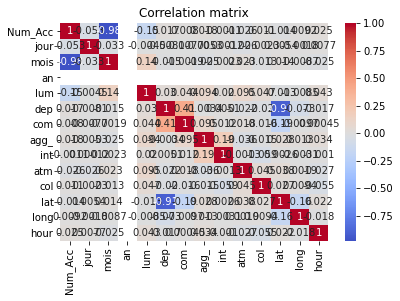

In [20]:
#--Visualizing correlations
df_numerical = df_caract.select_dtypes(include=['int64', 'float64', 'datetime'])

correlation_matrix = df_numerical.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation matrix')
plt.show()


# Dataset Vehicles 

In [21]:
df_veh.head()


,Num_Acc,id_vehicule,num_veh,senc,catv,obs,obsm,choc,manv,motor,occutc
0,202100000001,201Â 764,B01,1,1,0,2,1,1,5,NaN
1,202100000001,201Â 765,A01,1,7,0,9,3,17,1,NaN
2,202100000002,201Â 762,A01,0,7,2,2,1,1,0,NaN
3,202100000002,201Â 763,B01,0,7,0,2,1,9,0,NaN
4,202100000003,201Â 761,A01,1,7,0,1,3,1,1,NaN


In [22]:
df_veh.catv.unique()

array([ 1,  7, 60, 32, 99, 37, 10,  2, 15, 14,  0, 33, 31, 34, 30, 50,  3,
       39, 36, 13, 80, 43, 38, 20, 40, 17, 35, 21, 16, 41, -1, 42])

In [23]:
df_veh.isna().sum()

Num_Acc            0
id_vehicule        0
num_veh            0
senc               0
catv               0
obs                0
obsm               0
choc               0
manv               0
motor              0
occutc         96571
dtype: int64

# Merging datasets

In [24]:
df_users.head()

,Num_Acc,id_vehicule,num_veh,place,catu,grav,sexe,trajet,secu1,locp,actp,etatp,victim_age
0,202100000001,201Â 764,B01,1,1,4,1,1,0,0,0,-1,21.0
1,202100000001,201Â 765,A01,1,1,1,1,1,1,0,0,-1,43.0
2,202100000002,201Â 762,A01,1,1,2,1,0,1,0,0,-1,38.0
3,202100000002,201Â 763,B01,1,1,4,1,0,1,0,0,-1,28.0
4,202100000003,201Â 761,A01,1,1,1,1,1,1,0,0,-1,26.0


In [25]:
#--Merging datasets users and vehicles

fusion1= df_users.merge(df_veh, on = ["Num_Acc","num_veh", "id_vehicule"], how="inner")


In [26]:
#--Keeping 1 line by accident and keeping the most severe injured person

fusion1 = fusion1.sort_values(by = "grav", ascending = False)
fusion1 = fusion1.drop_duplicates(subset = ['Num_Acc'], keep="first")
fusion1.head()

,Num_Acc,id_vehicule,num_veh,place,catu,grav,sexe,trajet,secu1,locp,...,etatp,victim_age,senc,catv,obs,obsm,choc,manv,motor,occutc
0,202100000001,201Â 764,B01,1,1,4,1,1,0,0,...,-1,21.0,1,1,0,2,1,1,5,NaN
54384,202100023697,159Â 259,B01,1,1,4,1,0,2,-1,...,-1,38.0,1,30,0,2,1,1,1,NaN
54368,202100023689,159Â 273,A01,10,3,4,1,5,8,3,...,1,76.0,3,10,0,1,1,1,1,NaN
54351,202100023682,159Â 289,A01,10,3,4,2,5,0,2,...,3,11.0,3,7,0,1,2,1,1,NaN
54348,202100023681,159Â 291,B01,1,1,4,2,5,2,-1,...,-1,62.0,3,80,0,2,1,2,3,NaN


In [27]:
fusion2 = fusion1.merge(df_places, on = "Num_Acc", how = "left")

In [28]:
df = fusion2.merge(df_caract, on = 'Num_Acc', how="left")

In [29]:
df.head()

,Num_Acc,id_vehicule,num_veh,place,catu,grav,sexe,trajet,secu1,locp,...,dep,com,agg_,int,atm,col,lat,long,datetime,hour
0,202100000001,201Â 764,B01,1,1,4,1,1,0,0,...,30,30319,1,1,0,1,44.038958,4.348022,2021-11-30 07:32:00,7
1,202100023697,159Â 259,B01,1,1,4,1,0,2,-1,...,64,64483,1,1,0,1,43.391050,-1.628970,2021-08-17 13:15:00,13
2,202100023689,159Â 273,A01,10,3,4,1,5,8,3,...,74,74012,2,1,0,6,46.193620,6.235100,2021-08-17 11:19:00,11
3,202100023682,159Â 289,A01,10,3,4,2,5,0,2,...,84,84007,2,1,0,6,43.942340,4.827450,2021-05-23 19:20:00,19
4,202100023681,159Â 291,B01,1,1,4,2,5,2,-1,...,88,88160,2,6,0,3,48.192390,6.461570,2021-08-17 14:25:00,14


In [30]:
#--Adding the number of victims
df = df.merge(nb_victim, on = "Num_Acc", how = "inner")

df.rename({"count" :"nb_victim"},axis = 1, inplace = True) 



In [31]:
#--Adding the number of vehicles 

df = df.merge(nb_vehicules, on = "Num_Acc", how = "inner") 
df.rename({"count" :"nb_vehicules"},axis = 1, inplace = True)

In [32]:
df['grav'].unique()

array([4, 3, 2])

In [33]:
#--Modification of the target variable  : 1 : prioritary// 0 : non-prioritary

df['grav'].replace([2,3,4], [0,1,1], inplace=True)
df

,Num_Acc,id_vehicule,num_veh,place,catu,grav,sexe,trajet,secu1,locp,...,agg_,int,atm,col,lat,long,datetime,hour,nb_victim,nb_vehicules
0,202100000001,201Â 764,B01,1,1,1,1,1,0,0,...,1,1,0,1,44.038958,4.348022,2021-11-30 07:32:00,7,2,2
1,202100023697,159Â 259,B01,1,1,1,1,0,2,-1,...,1,1,0,1,43.391050,-1.628970,2021-08-17 13:15:00,13,2,2
2,202100023689,159Â 273,A01,10,3,1,1,5,8,3,...,2,1,0,6,46.193620,6.235100,2021-08-17 11:19:00,11,2,1
3,202100023682,159Â 289,A01,10,3,1,2,5,0,2,...,2,1,0,6,43.942340,4.827450,2021-05-23 19:20:00,19,5,1
4,202100023681,159Â 291,B01,1,1,1,2,5,2,-1,...,2,6,0,3,48.192390,6.461570,2021-08-17 14:25:00,14,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56513,202100013816,176Â 997,B01,1,1,0,1,1,2,0,...,2,6,0,3,41.929938,8.757052,2021-10-11 16:10:00,16,2,2
56514,202100014862,175Â 147,A01,1,1,0,2,9,1,-1,...,2,9,0,2,48.931427,2.486249,2021-10-06 21:49:00,21,2,2
56515,202100014653,175Â 520,A01,10,3,0,1,2,0,4,...,2,3,0,6,48.865000,2.453650,2021-10-07 15:10:00,15,2,1
56516,202100014861,175Â 149,A01,1,1,0,1,4,2,-1,...,2,2,0,1,48.906460,2.511900,2021-10-06 22:40:00,22,2,2


In [34]:

#--Calculating the number of missing values for each column
missing_values_count = df.isnull().sum()

#--Calculating the percentage of missing values for each variables 
total_cells = len(df)
missing_percentage = (missing_values_count / total_cells) * 100

#--Creating a new dataframe with the percentage of missing values 
missing_df = pd.DataFrame({'Column': missing_percentage.index, 'MissingPercentage': missing_percentage.values})

missing_df = missing_df.sort_values(by='MissingPercentage', ascending=False)

print(missing_df)

          Column  MissingPercentage
32        lartpc          99.808910
20        occutc          99.414346
24            v2          91.170954
22          voie           7.797516
0        Num_Acc           0.000000
29            pr           0.000000
31          plan           0.000000
33       larrout           0.000000
34          surf           0.000000
35         infra           0.000000
36          situ           0.000000
37           vma           0.000000
38          jour           0.000000
39          mois           0.000000
40            an           0.000000
41           lum           0.000000
42           dep           0.000000
43           com           0.000000
44          agg_           0.000000
45           int           0.000000
46           atm           0.000000
47           col           0.000000
48           lat           0.000000
49          long           0.000000
50      datetime           0.000000
51          hour           0.000000
52     nb_victim           0

In [35]:
#--Removing variables with more than 70% of missing values 
list_to_drop = ['v1', 'lartpc','occutc','v2','vosp','locp','etatp', 'infra', 'obs']

df.drop(list_to_drop, inplace=True, axis=1)

In [36]:
df.columns

Index(['Num_Acc', 'id_vehicule', 'num_veh', 'place', 'catu', 'grav', 'sexe',
       'trajet', 'secu1', 'actp', 'victim_age', 'senc', 'catv', 'obsm', 'choc',
       'manv', 'motor', 'catr', 'voie', 'circ', 'nbv', 'prof', 'pr', 'pr1',
       'plan', 'larrout', 'surf', 'situ', 'vma', 'jour', 'mois', 'an', 'lum',
       'dep', 'com', 'agg_', 'int', 'atm', 'col', 'lat', 'long', 'datetime',
       'hour', 'nb_victim', 'nb_vehicules'],
      dtype='object')

In [37]:
catv_value = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,30,31,32,33,34,35,36,37,38,39,40,41,42,43,50,60,80,99]
catv_value_new = [0,1,1,2,1,1,6,2,5,5,5,5,5,4,4,4,4,4,3,3,4,4,1,1,1,1,1,6,6,3,3,3,3,1,1,1,1,1,0,0]
df['catv'].replace(catv_value, catv_value_new, inplace = True)

In [38]:
#--Replacing values -1 et 0 par NaN
col_to_replace0_na = ["actp", "trajet", "catv", "motor"]
col_to_replace1_na = ["actp", "trajet", "secu1", "catv", "obsm", "motor", "circ", "larrout", "surf", "situ", "vma", "atm", "col"]
df2 = df.copy()
df[col_to_replace1_na] = df[col_to_replace1_na].replace(-1, np.nan)
df[col_to_replace0_na] = df[col_to_replace0_na].replace(0, np.nan)

In [39]:
for column in df.columns[15:]:
    print(f"Modalities of the variable {column} : ", df[column].unique())

Modalities of the variable manv :  [ 1  2 21 17 13 19  3 14  9  0 10  6 16  5 26 15 24 23 11 25 12  4 20  7
 18  8 -1 22]
Modalities of the variable motor :  [ 5.  1.  3. nan  2.  6.  4.]
Modalities of the variable catr :  [3 4 2 7 5 6 1 9]
Modalities of the variable voie :  ['981' 'SAINT PEE (VIEILLE ROUTE DE)' 'PASTEUR (AVENUE)' ...
 'FRATERNITE (PLACE)' 'ASPRETTO ROUTE' 'ESTIENNE (AL. ROBERT)']
Modalities of the variable circ :  [ 2.  1.  3.  4. nan]
Modalities of the variable nbv :  [ 2  1  4  3  0  5 -1  6  7  8 12 10  9 11]
Modalities of the variable prof :  [ 1  2  3  4 -1]
Modalities of the variable pr :  ['(1)' '2' '0' '39' '72' '88' '16' '23' '26' '37' '6' '82' '33' '5' '21'
 '1' '10' '32' '45' '4' '8' '11' '17' '132' '12' '79' '15' '31' '27' '61'
 '46' '9' '14' '50' '22' '69' '115' '48' '40' '38' '68' '51' '18' '52'
 '36' '3' '30' '44' '20' '54' '25' '191' '34' '7' '59' '67' '42' '76' '57'
 '103' '74' '28' '93' '49' '53' '43' '75' '13' '35' '63' '19' '66' '145'
 '87' '278' '

In [40]:
#--Removing variables that do not match with our goal to predict the severity of the accident 

list_to_drop = ['senc', 'manv', 'choc', 'nbv', 'prof', 'plan', 'Num_Acc', 'id_vehicule', 'num_veh', 'pr', 'pr1', 'trajet' ]
# ,'voie'
df.drop(list_to_drop, axis=1, inplace=True)

In [41]:
#--Replacing modalities A and B by 10 and 11
df["actp"] = df["actp"].str.replace("A","10")
df["actp"] = df["actp"].str.replace("B","11")
df["actp"] = df["actp"].astype(int)

In [42]:
df.select_dtypes(['object']).columns

Index(['voie', 'larrout'], dtype='object')

In [43]:
df['voie'].unique()

array(['981', 'SAINT PEE (VIEILLE ROUTE DE)', 'PASTEUR (AVENUE)', ...,
       'FRATERNITE (PLACE)', 'ASPRETTO ROUTE', 'ESTIENNE (AL. ROBERT)'],
      dtype=object)

In [44]:
#--Converting larrout into float
df["larrout"] = df["larrout"].str.replace(",",".")
df["larrout"] = df["larrout"].astype(float)

In [45]:
#--Fill NaN with mode 
col_to_fill_na = ["surf", "situ", "circ", "col", "motor"]

df[col_to_fill_na] = df[col_to_fill_na].fillna(df[col_to_fill_na].mode().iloc[0])


In [46]:
#Drop NaN 

df = df.dropna(axis=0)

In [47]:
# Finale version of the preprocessing steps :

#--Importing dataset
df_users=pd.read_csv(abs_path+"/data/raw/usagers-2021.csv", sep=";")
df_places=pd.read_csv(abs_path+"/data/raw/lieux-2021.csv", sep=";", header=0, low_memory=False)
df_caract=pd.read_csv(abs_path+"/data/raw/caracteristiques-2021.csv", sep = ";", encoding='utf-8')
df_veh=pd.read_csv(abs_path+"/data/raw/vehicules-2021.csv", sep=";")


nb_victim = pd.crosstab(df_users.Num_Acc, "count").reset_index()
nb_vehicules = pd.crosstab(df_veh.Num_Acc, "count").reset_index()
df_users["year_acc"] = df_users["Num_Acc"].astype(str).apply(lambda x : x[:4]).astype(int)
df_users["victim_age"] = df_users["year_acc"]-df_users["an_nais"]
for i in df_users["victim_age"] :
        if (i>120)|(i<0):
                df_users["victim_age"].replace(i,np.nan)
df_caract["hour"] = df_caract["hrmn"].astype(str).apply(lambda x : x[:-3])
df_caract.drop(['hrmn', 'an'], inplace=True, axis=1)
df_users.drop(['an_nais'], inplace=True, axis=1)

#--Replacing names 
df_users.grav.replace([1,2,3,4], [1,3,4,2], inplace = True)
df_caract.rename({"agg" : "agg_"},  inplace = True, axis = 1)
corse_replace = {"2A":"201", "2B":"202"}
df_caract["dep"] = df_caract["dep"].str.replace("2A", "201")
df_caract["dep"] = df_caract["dep"].str.replace("2B", "202")
df_caract["com"] = df_caract["com"].str.replace("2A", "201")
df_caract["com"] = df_caract["com"].str.replace("2B", "202")

#--Converting columns types
df_caract[["dep","com", "hour"]] = df_caract[["dep","com", "hour"]].astype(int)

dico_to_float = { 'lat': float, 'long':float}
df_caract["lat"] = df_caract["lat"].str.replace(',', '.')
df_caract["long"] = df_caract["long"].str.replace(',', '.')
df_caract = df_caract.astype(dico_to_float)


#--Grouping modalities 
dico = {1:0, 2:1, 3:1, 4:1, 5:1, 6:1,7:1, 8:0, 9:0}
df_caract["atm"] = df_caract["atm"].replace(dico)
catv_value = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,30,31,32,33,34,35,36,37,38,39,40,41,42,43,50,60,80,99]
catv_value_new = [0,1,1,2,1,1,6,2,5,5,5,5,5,4,4,4,4,4,3,3,4,4,1,1,1,1,1,6,6,3,3,3,3,1,1,1,1,1,0,0]
df_veh['catv'].replace(catv_value, catv_value_new, inplace = True)

#--Merging datasets 
fusion1= df_users.merge(df_veh, on = ["Num_Acc","num_veh", "id_vehicule"], how="inner")
fusion1 = fusion1.sort_values(by = "grav", ascending = False)
fusion1 = fusion1.drop_duplicates(subset = ['Num_Acc'], keep="first")
fusion2 = fusion1.merge(df_places, on = "Num_Acc", how = "left")
df = fusion2.merge(df_caract, on = 'Num_Acc', how="left")

#--Adding new columns
df = df.merge(nb_victim, on = "Num_Acc", how = "inner")
df.rename({"count" :"nb_victim"},axis = 1, inplace = True) 
df = df.merge(nb_vehicules, on = "Num_Acc", how = "inner") 
df.rename({"count" :"nb_vehicules"},axis = 1, inplace = True)

#--Modification of the target variable  : 1 : prioritary // 0 : non-prioritary
df['grav'].replace([2,3,4], [0,1,1], inplace=True)


#--Replacing values -1 and 0 
col_to_replace0_na = [ "trajet", "catv", "motor"]
col_to_replace1_na = [ "trajet", "secu1", "catv", "obsm", "motor", "circ", "surf", "situ", "vma", "atm", "col"]
df[col_to_replace1_na] = df[col_to_replace1_na].replace(-1, np.nan)
df[col_to_replace0_na] = df[col_to_replace0_na].replace(0, np.nan)


#--Dropping columns 
list_to_drop = ['senc','larrout','actp', 'manv', 'choc', 'nbv', 'prof', 'plan', 'Num_Acc', 'id_vehicule', 'num_veh', 'pr', 'pr1','voie', 'trajet',"secu2", "secu3",'adr', 'v1', 'lartpc','occutc','v2','vosp','locp','etatp', 'infra', 'obs' ]
df.drop(list_to_drop, axis=1, inplace=True)

#--Dropping lines with NaN values
col_to_drop_lines = ['catv', 'vma', 'secu1', 'obsm', 'atm']
df = df.dropna(subset = col_to_drop_lines, axis=0)


target = df['grav']
feats = df.drop(['grav'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(feats, target, test_size=0.3, random_state = 42)

#--Filling NaN values
col_to_fill_na = ["surf", "circ", "col", "motor"]
X_train[col_to_fill_na] = X_train[col_to_fill_na].fillna(X_train[col_to_fill_na].mode().iloc[0])
X_test[col_to_fill_na] = X_test[col_to_fill_na].fillna(X_train[col_to_fill_na].mode().iloc[0])

In [48]:
X_train.shape

(38288, 28)

In [49]:
# Select lines to run a gridsearch 
num_random_rows = 5000
X_train_reduced = X_train.sample(n=num_random_rows, random_state = 42)
X_train_reduced.shape
y_train_reduced = y_train.sample(n=num_random_rows, random_state = 42)

In [50]:
# Select best features for the median for categorical variables

selector_median = SelectFromModel(SGDClassifier(random_state = 0), threshold = 'median')

selector_median.fit_transform(X_train, y_train)

feats_sgdc_med = feats.columns[selector_median.get_support()]
print("les va les plus explicatives selectionnées par mediane sont:", feats.columns[selector_median.get_support()])

les va les plus explicatives selectionnées par mediane sont: Index(['place', 'secu1', 'victim_age', 'obsm', 'situ', 'vma', 'jour', 'dep',
       'agg_', 'int', 'col', 'lat', 'long', 'nb_vehicules'],
      dtype='object')


In [51]:
lr_select = LogisticRegression(class_weight='balanced')
lr_select.fit(X_train_reduced, y_train_reduced)

# Visualization of false positives and false negatives

y_pred_lr = lr_select.predict(X_test)

print(pd.crosstab(y_test, y_pred_lr, rownames=['Classe réelle'], colnames=['Classe prédite']))


Classe prédite     0     1
Classe réelle             
0               7024  3713
1               2142  3531


/usr/lib64/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [52]:
f1_score_value = f1_score(y_test, y_pred_lr)

print("F1-score:", f1_score_value)

F1-score: 0.5467213749322598


In [53]:
dt_clf = DecisionTreeClassifier(criterion = 'entropy', max_depth=4, random_state=123)

dt_clf.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=123)

In [54]:

# Prediction of test features and creation of the confusion matrix
y_pred = dt_clf.predict(X_test)
pd.crosstab(y_test, y_pred, rownames=['Real class'], colnames=['Predict class'])
f1_score_value = f1_score(y_test, y_pred)

print("F1-score:", f1_score_value)

F1-score: 0.5738681493248611


In [55]:
feats = {}
for feature, importance in zip(df.columns, dt_clf.feature_importances_):
    feats[feature] = importance 
    
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'})
importances.sort_values(by='Importance', ascending=False).head(8)


,Importance
col,0.299050
dep,0.209494
situ,0.193397
motor,0.117135
lat,0.075248
catr,0.031973
nb_victim,0.030220
com,0.027889


In [56]:
dt_clf_gini = DecisionTreeClassifier(criterion='gini', max_depth=8, random_state=321)
dt_clf_gini.fit(X_train, y_train)
y_pred = dt_clf_gini.predict(X_test)
pd.crosstab(y_test, y_pred, rownames=['Real class'], colnames=['Predict class'])
f1_score_value = f1_score(y_test, y_pred)

print("F1-score:", f1_score_value)

F1-score: 0.6113811838718902


In [57]:
knn = neighbors.KNeighborsClassifier(n_neighbors = 7, metric = 'minkowski')

knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print(f1_score(y_test, y_pred))

0.5923844588702645


In [58]:
score_minko = []
score_man = []
score_cheb = []

for i in range(1, 10):
    knn_mink = neighbors.KNeighborsClassifier(n_neighbors = i, metric = 'minkowski').fit(X_train_reduced.values, y_train_reduced.values)
    knn_man = neighbors.KNeighborsClassifier(n_neighbors = i, metric = 'manhattan').fit(X_train_reduced.values, y_train_reduced.values)
    knn_cheb = neighbors.KNeighborsClassifier(n_neighbors = i, metric = 'chebyshev').fit(X_train_reduced.values, y_train_reduced.values)
    y_pred_mink = knn_mink.predict(X_test.values)
    y_pred_man = knn_man.predict(X_test.values)
    y_pred_cheb = knn_cheb.predict(X_test.values)
    score_minko.append(f1_score(y_test, y_pred_mink))
    score_man.append(f1_score(y_test, y_pred_man))
    score_cheb.append(f1_score(y_test, y_pred_cheb))

print(score_minko)

[0.5073099415204678, 0.3829578844270323, 0.5278402974850768, 0.4487445289103893, 0.5335846810199425, 0.47221914162138184, 0.5365804970555944, 0.4863611264494755, 0.5280864512182688]


In [59]:
rf_classifier = ensemble.RandomForestClassifier(n_jobs=-1)

#--Train the model
rf_classifier.fit(X_train, y_train)

y_pred_rf = rf_classifier.predict(X_test)
f1 = f1_score(y_test, y_pred_rf)


X_test.head()


,place,catu,sexe,secu1,year_acc,victim_age,catv,obsm,motor,catr,...,com,agg_,int,atm,col,lat,long,hour,nb_victim,nb_vehicules
25457,1,1,1,1.0,2021,25.0,2.0,2.0,1.0,4,...,1053,2,2,1.0,3.0,46.195610,5.221920,22,2,2
16942,10,3,1,0.0,2021,60.0,2.0,1.0,1.0,3,...,77317,2,1,0.0,6.0,48.607146,2.890515,17,2,1
43032,1,1,1,2.0,2021,47.0,1.0,0.0,1.0,7,...,69034,2,3,0.0,6.0,45.799725,4.876803,16,1,1
38963,1,1,1,2.0,2021,28.0,1.0,2.0,1.0,2,...,97611,2,1,0.0,1.0,-12.775820,45.226830,16,2,2
15926,1,1,1,2.0,2021,17.0,1.0,2.0,1.0,3,...,30174,2,1,0.0,6.0,44.028624,4.378697,10,1,1


In [60]:
clf = ensemble.RandomForestClassifier()

# Définir la grille des hyperparamètres à explorer
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Créer l'objet GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='f1')

# Effectuer la recherche sur la grille
grid_search.fit(X_train_reduced, y_train_reduced)

# Afficher les meilleurs paramètres et score
print("Meilleurs paramètres:", grid_search.best_params_)
print("Meilleur score F1:", grid_search.best_score_)

# Utiliser le modèle avec les meilleurs paramètres
best_clf = grid_search.best_estimator_
y_pred_rf = best_clf.predict(X_test)

# Calculer et afficher le score F1 sur les données de test
f1 = f1_score(y_test, y_pred_rf)
print("Score F1 sur les données de test:", f1)

Meilleurs paramètres: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Meilleur score F1: 0.5740291723192821
Score F1 sur les données de test: 0.6086345381526105


In [61]:
dico = {"place": 0,
"catu": 0,
"sexe" : 0,
"secu1" : 0.0,
"year_acc" : 0,
"victim_age" : 0,
"catv" : 0,
"obsm" : 0,
"motor" : 0,
"catr" : 0,
"circ" : 0,
"surf" : 0,
"situ" : 0,
"vma" : 0,
"jour" :0,
"mois" : 0,
"lum" : 0,
"dep" : 0,
"com" : 0,
"agg_" : 0,
"int" : 0,
"atm" : 0,
"col" :0, 
"lat" : 0,
"long" : 0,
"hour" : 0,
"nb_victim" : 0,
"nb_vehicules" : 0}

df_test = pd.DataFrame([dico])
print(rf_classifier.predict(df_test))

[1]


In [62]:
# Supprimez la limite de lignes et de colonnes pour l'affichage
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
y_pred_rf
X_test.head()

,place,catu,sexe,secu1,year_acc,victim_age,catv,obsm,motor,catr,circ,surf,situ,vma,jour,mois,lum,dep,com,agg_,int,atm,col,lat,long,hour,nb_victim,nb_vehicules
25457,1,1,1,1.0,2021,25.0,2.0,2.0,1.0,4,2.0,2.0,1.0,50.0,8,12,5,1,1053,2,2,1.0,3.0,46.195610,5.221920,22,2,2
16942,10,3,1,0.0,2021,60.0,2.0,1.0,1.0,3,2.0,1.0,1.0,50.0,7,12,5,77,77317,2,1,0.0,6.0,48.607146,2.890515,17,2,1
43032,1,1,1,2.0,2021,47.0,1.0,0.0,1.0,7,2.0,1.0,1.0,50.0,1,4,1,69,69034,2,3,0.0,6.0,45.799725,4.876803,16,1,1
38963,1,1,1,2.0,2021,28.0,1.0,2.0,1.0,2,2.0,1.0,1.0,50.0,13,5,1,976,97611,2,1,0.0,1.0,-12.775820,45.226830,16,2,2
15926,1,1,1,2.0,2021,17.0,1.0,2.0,1.0,3,2.0,1.0,1.0,50.0,14,12,1,30,30174,2,1,0.0,6.0,44.028624,4.378697,10,1,1


In [1]:
import imblearn
from imblearn.over_sampling import RandomOverSampler, SMOTE


rOs = RandomOverSampler()
X_ro, y_ro = rOs.fit_resample(X_train, y_train)
print('Classes échantillon oversampled :', dict(pd.Series(y_ro).value_counts()))
pi 
#SMOTE
smo = SMOTE()
X_sm, y_sm = smo.fit_resample(X_train, y_train)
print('Classes échantillon SMOTE :', dict(pd.Series(y_sm).value_counts()))


ModuleNotFoundError: No module named 'imblearn'